# Semester Project
## How much corn syrup and sugar are brands using in today’s products?

Session 1 Team 6
* Nitika Kataria (NK3RF) - nk3rf@virginia.edu
* Robert Knuuti (UQQ5ZZ) - uqq5zz@virginia.edu
* Swaroop Veerabhadrappa (SBV5DN) - sbv5dn@virginia.edu

School of Data Science, University of Virginia

CS 5010: Programming and Systems for Data Science

Dr. Judy Fox

May 5th, 2021

----

## A Note to Reviewers

While this notebook serves as an example of our analysis, code was modified to support running in the Google Colabratory notebook format.  Our project was designed to work as a python module, as such we have ported our code to adapt to this alternate platform to maximize our audience.

It is _strongly_ recommended you check out the code from git and run the project directly on your workstation if you experence any issues running this notebook, as there is limited control over google's provided libraries, and future executions of this notebook may have inconsistent results.

See our [Github](https://github.com/uva-sp2021-cs5010-g6/finalproject) repository for more details, and for [bootstrapping](https://github.com/uva-sp2021-cs5010-g6/finalproject/blob/main/GETSTARTED.rst) instructions.

In [1]:
!pip install --upgrade pytest
!pip install ipytest jupyter-pytest-2

Requirement already up-to-date: pytest in /usr/local/lib/python3.7/dist-packages (6.2.4)


# Stop!

You will need to restart your runtime to include the newly installed libraries.

You can do this by clicking "Runtime -> Restart Runtime" or by pressing `Ctrl+M`, or by clicking the button to "restart runtime" in the above cell.  Once completed, you can continue running this notebook.

In [2]:
# Adding the source URI for the fetcher object
!echo "https://fdc.nal.usda.gov/fdc-datasets/FoodData_Central_csv_2020-10-30.zip" > uri.txt
!mkdir -p "dataset"

In [3]:
## project01.fetch
"""Data fetching utility for USDA datasets.

This module provides the primary support functions for downloading datasets from
a text file.  Each line in the text file is expected to be a complete URL.  Lines
that begin with '#' are ignored.

Example:

    This module can be run directly with the following arguments:
    
    $ python -m project01.fetch path/to/uri.txt output/dir

    The URIs listed in the file path/to/uri.txt will be Files will be saved to output/dir.

    If no arguments are specified, they defaults (./uri.txt, and ./dataset)
"""

import os
import sys

import requests
import tempfile
import zipfile


class Fetcher:
    def __init__(self, uris: str = "uri.txt", base: str = "dataset", feedback: bool = True):
        """Creates a new fetcher method configured with the arguments specified.

        Args:
            uris (str): A path to a URI file for the class to parse and download the
                datasetsfrom
           base (str): A path to a directory to write the resulting files to.
           feedback (bool): Specifies if user feedback during the download process
               should occur.  When true, text is written to stdout.
        """
        self._uris = self.__parse_file(uris)
        self._base = base
        self._feedback = feedback

    @staticmethod
    def __parse_file(uri_file):
        """Establishs a link of URIs to download.
        
        Args:
            uri_file (str): the path to the file to parse.
        Returns:
            list(str): The effective listing of URIs from the uri_file.
        """
        ret = list()
        with open(uri_file, "r") as uris:
            for uri in uris:
                if not uri.startswith("#"):
                    ret.append(uri.rstrip())
        return ret

    def add_uri(self, uri: str):
        """Adds a URI to the list of download links after creation of the object.

        Args:
            uri (str): A fully qualified string to fetch to artifact from
        Returns:
            list(str): A listing of all URIs the instance is currently configured
                to support.
        """
        self._uris.append(uri)
        return self._uris

    def fetch(self, feedback: bool = None, out: str = None) -> str:
        """Downloads all URIs the the current object and extracts them to the class's directory.

        Args:
            feedback(bool): Overide the classes feedback state.  If True, the download
                progress will be echoed to screen.
            out(str): Overrides the classes output director.  If specified, the downloaded
                files will be written to the directory that has been specified.
        Returns:
            str: The output path of the extracted files.
        """
        feedback = feedback if feedback is not None else self._feedback
        out = out if out is not None else self._base
        with tempfile.TemporaryDirectory() as temp_dir:
            for uri in self._uris:
                filename = os.path.basename(uri)
                # Use stream to download very large files
                resp = requests.get(uri, stream=True)
                resp.raise_for_status()
                uri_size = resp.headers.get('content-length')  # Get the size of the download
                if feedback:
                    print("Downloading {}".format(uri))
                with open(os.path.join(temp_dir, filename), "wb") as zipf:
                    tracker = 0
                    for block in resp.iter_content(4096):
                        tracker += len(block)
                        zipf.write(block)
                        if feedback:
                            done = int(50 * tracker / int(uri_size))  # Total Progress
                            # We need an unbuffered printer here...
                            sys.stdout.write("\r[%s%s] %s/100" % ('=' * done, ' ' * (50-done), done*2))
                            sys.stdout.flush()
                    print("")
            for root, dirs, files in os.walk(temp_dir):
                for zipf in files:
                    temp_zip = os.path.join(root, zipf)
                    with zipfile.ZipFile(temp_zip, "r") as zf:
                        if feedback:
                            print("Extracting {}".format(zipf))
                        stripped_name, ext = os.path.splitext(temp_zip)
                        basen = os.path.basename(stripped_name)
                        zf.extractall(os.path.join(out, basen))
        return out

## Removed as this code functions only properly as a python module
#def cli():
#    """Creates a CLI parser
#
#    Returns:
#        argparse.ArgumentParser: An Argument Parser configured to support the
#            fetcher class.
#    """
#    import argparse
#    parser = argparse.ArgumentParser("Fetch datasets")
#
#    parser.add_argument("urifile", nargs="?",
#                        default="uri.txt",
#                        help="Path to file containing URIs to download.")
#    parser.add_argument("outdir", nargs="?",
#                        default="dataset",
#                        help="Path to a directory to output the files.")
#    return parser
#
#
#def main(uri_file, out):
#    collector = Fetcher(uris=uri_file, base=out)
#    collector.fetch()

In [4]:
udsa_downloader = Fetcher(uris="uri.txt", base="dataset")
udsa_downloader.fetch()

[==================================================] 100/100
Extracting FoodData_Central_csv_2020-10-30.zip


'dataset'

In [5]:
# project01.parser
"""
This module contains the shared code used to read, parse, and produce
a dataframe object using our USDA dataset.  Reviewing our dataset, we
find that there's several common columns and indices, indicating that
we could adopt an object-oriented approach, where we have a base object
and each of our data tables could expand upon.

"""

import os
import re
from typing import Any, List, Optional

import pandas as pd


class BaseFood:
    """A base object for USDA food elements.
    
    This object creates a common interface for all future USDA food table
    entries.
    """
    def __init__(self, csv_file: str = None, *args, **kwargs) -> None:
        self._df = self._parse_csv(csv_file)
        self._ingredients = None

    @staticmethod
    def _parse_csv(csv_file: str) -> pd.DataFrame:
        """Establishes a pandas dataframe of the passed CSV file

        Args:
            csv_file (str): A string representing the path of the CSV file
               to load
        Returns:
           pd.DataFrame: The CSV file loaded as a dataframe.
        """
        return pd.read_csv(csv_file, header=0, dtype=object)

    def _filter(self, col: str, val: Any) -> pd.DataFrame:
        """Returns the rows of the dataframe which have the passed value in the specified column.

        Args:
            col (str): The name of the column in the current instance's dataframe.
            val (Any): The value to seek on within the dataframe.
        Returns:
            pd.DataFrame: The subset of the dataframe which matches the above condition.
        """
        return self._df[self._df[col] == val]

    def find_by_fdcid(self, idx: int) -> pd.DataFrame:
        """Returns the record whos fdc_id matches teh passed id value.

        Args:
            idx (int): The Index ID used for the food object.
        Returns:
            pd.DataFrame: The subset of the datatframe that matches the passed ID.

        """
        return self._filter("fdc_id", idx)

    @property
    def df(self) -> pd.DataFrame:
        """Provides access to the object's dataframe
        """
        return self._df

    def run_on_df(self, func, *args, **kwargs):
        self._df = func(self._df, *args, **kwargs)
        return self._df

    def cleanup(self) -> pd.DataFrame:
        """Cleans up dataset based upon EDA analysis.

        Returns:
            pd.DataFrame: The cleaned dataframe.
        """
        raise NotImplementedError("Base cleanup method must be implemented in subclasses of object.")

    def clamp(self,
              floor: int = 0,
              ceiling: int = None,
              col: str = "corn_syrup_idx") -> pd.DataFrame:
        """Clamping function used to filter the allowed indices of a column.

        Args:
            floor (int): The lowest allowed value of the column. Defaults to 0.
            ceiling (int): The highest allowed value in the column.
                Defaults to the maximum value in the column.
            col (str): The column name to operate on.  Defaults to corn_syrup_idx.

        Returns:
            pd.DataFrame: A new dataframe, where only the rows within the values
                of floor and ceiling are included, and all others are dropped.
        """
        ceil = ceiling if ceiling is not None else self._df[col].max() + 1
        self._df = self._df[(self._df[col] > floor) & (self._df[col] < ceil)]
        return self._df

    def find_top(self,
                 limit: int = 5,
                 col: str = "branded_food_category") -> pd.DataFrame:
        """Establishes the dataset for finding the largest values in the food object.

        Args:
            limit (int): The total number of records to return from the dataset.
            col (str): The column to find the top occurances of.
        Returns:
            pd.DataFrame: A filtered dataframe containing only the foods
            in the top five largest categories.
        """
        top_series = self._df[col].value_counts().nlargest(limit)
        top_names = top_series.index.array
        self._df = self._df[self._df[col].isin(top_names)]
        return self._df

    def __str__(self) -> str:
        return self._df.__str__()


class FoodObject(BaseFood):
    def __init__(self, csv_file: str = None) -> None:
        """An object implementation of the food.csv data table.

        Args:
           csv_file (str): A string that direccts to the food.csv file.
        """
        super().__init__(csv_file)

    def find_by_group(self, grp: str) -> pd.DataFrame:
        """Finds all records that match the passed group.

        Args:
            grp (str): The group name to look up in the dataframe.
        Returns:
            pd.DataFrame: A subset of the dataframe for the specified group.
        """
        return self._filter("food_category_id", grp)

    def cleanup(self):
        raise NotImplementedError("To be implemented.")


class FoodBrandObject(BaseFood):
    def __init__(self, csv_file: str = None) -> None:
        """Establishs a new FoodBrand object based on the food_brand.csv file

        Args:
            csv_file (str): A string that specifies the path of the food_brands.csv file.
        """
        super().__init__(csv_file)

    def find_by_brandowner(self, brand: str = None) -> pd.DataFrame:
        """Finds all records owned by a particular brand.

        Args:
            brand (str): The brand owner's fully named value
        Returns:
            pd.DataFrame: A subset of the data for the specified brand owner.
        """
        return self._filter("brand_owner", brand)

    def cleanup(self) -> pd.DataFrame:
        """Cleans up dataset based upon EDA analysis.

        Returns:
            pd.DataFrame: The cleaned dataframe.
        """
        self._df['modified_date'] = pd.to_datetime(self._df['modified_date'], format="%Y-%m-%d")
        self._df['available_date'] = pd.to_datetime(self._df['available_date'], format='%Y-%m-%d')
        # self._df['discontinued_date'] = pd.to_datetime(self._df['discontinued_date'], format='%Y-%m-%d')
        del self._df['discontinued_date']
        self._df.dropna(how='all')
        self._df.dropna(subset=['brand_owner', 'ingredients', 'serving_size',
                                'serving_size_unit', 'branded_food_category'], inplace=True)
        return self._df

    def get_all_ingredients(self):
        """Parses the entire ingridents series of the dataframe to establish a list of all ingredients.

        Returns:
           set: A set of the ingredients within the dataframe.
        """
        def clean(ing):
            """Performs simple splitting and parsing of an ingredients list.

            Args:
                ing (str): a string representing a product's ingriedents list.

            Returns:
                tuple: A split list of ingredients after being normalized for later processing.
            """
            # Strip paren text
            # Remove paren and bracket text
            cleaned1 = re.sub(r'[\(\[].*?[\)\]]', "", str(ing))  # noqa
            # Remove residual punctuation, save our "comma" delimiter
            cleaned2 = re.sub(r'[#.:\-*?!&}{\]\[\(\)"]', "", cleaned1)  # noqa
            # Return a tuple split on the comma, removing whitespace
            pt1 = list(i.strip() for i in cleaned2.lower().split(","))
            # Split on nested semicolon list for ingredients
            pt2 = list(i.strip() for lst in pt1 for i in lst.split(";"))
            # Split on subsequent ingredients
            pt3 = list(i.strip() for lst in pt2 for i in lst.split(":"))
            # Split on "statement" ingredients
            pt4 = list(i.strip() for lst in pt3 for i in lst.split("."))
            # Return as an immutable type to make converting to a set easier
            return tuple(pt4) 
        # Unfold the list into a flattened set and then back to a list (for ease of access)
        self._ingredients = tuple(set(x.strip() for lst in self._df["ingredients"].apply(clean).tolist() for x in lst))
        return self._ingredients


def load(csv_dir: Optional[str] = "dataset") -> List[FoodObject]:
    ret = list()

    for base_dir in os.listdir(csv_dir):
        ret.append(FoodObject(os.path.join(csv_dir, base_dir, "food.csv")))
    return ret


def find_index_from_str(delimited_string: str, fnd: str, split: str = ","):
    """Finds the rank of the string fnd in the passed delimited string

    This function takes in a raw string with a known delimiter and locates
    the index position of the fnd value, identifying the rank of the item.

    Args:
        delimited_string (str): The string to operate against.
        fnd (str): The string to search for
        split (str): The delimiter to use to split the source string.
           Default: ","

    Returns:
        int: The integer value representing where the string fnd is
        positioned in an array delimited by split.
    """
    key = fnd.lower()
    lst = [x.strip().lower() for x in str(delimited_string).split(split)]
    rank = -1
    for idx in range(len(lst)):
        try:
            lst[idx].index(key)
            rank = idx+1
            break
        except ValueError:
            continue
    return rank


def insert_index(df: pd.DataFrame,
                 find: str,
                 col: str = "ingredients",
                 sep: str = ",") -> pd.DataFrame:
    """Augments dataframe to add a ranked index column.

    This function inspects an existing dataframe's column and
    seeks for a specified string using the logic of `find_index_from_str`

    Args:
        df (pd.DataFrame: The dataframe to operate on.
        find (str): The string to search for
        col (str): The name of the column to operate on in the dataframe.
        sep (str): The delimiter to split the column's values against.

    Returns:
        pd.DataFrame: The mutated dataframe `df` with a new column named `find`_idx
        with the index value specified.  Note that if the value is not found, the
        column's value will be less than 0.
    """
    newcol = "".join([find.replace(" ", "_").lower(), "_idx"])
    df[newcol] = df[col].apply(find_index_from_str, fnd=find, split=sep)
    return df

In [6]:
# project01.EDA

"""

Investigating the use of corn syrup in food products:

Exploratory Data Analysis (EDA)
&
Data Cleanup

"""
print(">>>>>>>>>>----------<<<<<<<<<<")
print("Import Operating System")
print(">>>>>>>>>>----------<<<<<<<<<<\n")


import os
from typing import Any, List, Optional
    #import operating system
print(">>>>>>>>>>----------<<<<<<<<<<")
print("Import Libraries")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
    #import libraries

print(os.getcwd())
    #check working directory
print("\n>>>>>>>>>>----------<<<<<<<<<<")
print("Reading in Data Set")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

#import project01.parser as parser
    #import in the parser.py  file from the project01 folder so we can
    #instantiate Classes and call functions created within the parser.py script

branded_food = BaseFood('./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv')
#branded_food = parser.BaseFood('/Users/swaroopveerabhadrappa/PycharmProjects/finalproject/dataset/FoodData_Central_csv_2020-10-30/branded_food.csv')
    #loading the data set
    #create a object  by instantiating BaseFood class, which is designed to create
    # a Data Frame out of a passed in CSV file, which in this case is "branded_food.csv"

print(">>>>>>>>>>----------<<<<<<<<<<")
print("High-level Exploration of Data Set")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

branded_food.run_on_df(insert_index,find="corn syrup")
#branded_food.run_on_df(parser.insert_index,find="corn syrup")
    #use the branded_food_df Data Frame to call the nested function, insert_index
    #the insert_index function creates a new column with the index position of the value we're looking for
    #which in this case is 'corn syrup.' The insert_index function passes in another function when called,
    #find_index_from_str, which locates the index position of the value we're looking for

print("View first 3 rows of data\n")

print(tabulate(branded_food.df.head(3), headers='keys', tablefmt='psql'))
    #view first 3 rows of DataFrame
    #based on output, number of columns to display will need to be set

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

pd.set_option('display.max_columns', None)
    #use display.max_columns to print all the columns

print("View first 3 rows of data\n")
print(tabulate(branded_food.df.head(3), headers='keys', tablefmt='psql'))
    #check to see if all columns are displayed --> confirmed

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("Shape of DataFrame\n")
print(branded_food.df.shape)
    #shape attribute informs us of number of observations (rows) of data and number of
    #variables (columns) in data set:
        #498,182 rows
        #14 variables
print("/n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

pd.set_option('display.max_columns', None)
    #use display.max_columns to print all the columns

print("Information on DataFrame\n")
print(branded_food.df.info)
    #provides information about dataset including data types for each variable
        #date variables (modified_date, available_date, and discontinued_date variables) are
        #listed as 'object', change to datetime
    #we have a few categorical variables that need to be changed in data type

print(">>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("Convert date columns to datetime format\n")
branded_food.df['modified_date'] = pd.to_datetime(branded_food.df['modified_date'], infer_datetime_format='yyyy-mm-dd')
branded_food.df['available_date'] = pd.to_datetime(branded_food.df['available_date'], infer_datetime_format='yyyy-mm-dd')
branded_food.df['discontinued_date'] = pd.to_datetime(branded_food.df['discontinued_date'], infer_datetime_format='yyyy-mm-dd')

    #convert the date variables into datetime data type and use infer_datetime_format to automatically
    #have Pandas recognize the format, without having to specify a particular format

print("Data Type for each Column\n")
print(branded_food.df.dtypes)
    #confirm that date variables are now in datetime data type
        #confirmed

print(">>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("Summary Statistics\n")

print(branded_food.df.describe)
    #describe method provides count, mean, standard deviation, min, percentile values, and max
        #need to suppress scientific notation and set number of decimal places to 2

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

pd.set_option('display.float_format', lambda x: '%.2f' %x)
    #suppress scientific notation in Pandas
pd.options.display.float_format = "{:,.2f}".format
    #display float variables to two decimal places

print(branded_food.df.describe)
    #confirm that scientific notation is suppressed and number of decimal places = 2

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print("Data Cleanup: Checking for Missing Values, Duplicate Records, and Outliers")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("Missing Values in DataFrame\n")
print(branded_food.df.isnull().sum())

# print(branded_food.df.isnull().sum())
    #check DataFrame for null values in any column, and sum up the total null values
        #we observe null values in these columns: brand_owner, ingredients, serving_size
        #serving_size_unit, household_serving_fulltext, branded_food_category, and discontinued_date
    #we have the following options to deal with null values: drop from data se or
    #replace with mean/median/mode, which will be dependent on data type of variable
        #it wouldn't make sense to use mean/median with variables with data type object
        #it also wouldn't make sense to use mode with object values, nonsensical
    #one column is entirely blank, and that is discontinued_date
        #let's drop rows and columns if all values are null, and then
        #let's  drop discontinued_date column from Data Frame and then come back to missing values

del branded_food.df['discontinued_date']
    #drop discontinued_date column

print("\nColumns in DataFrame\n")

print(branded_food.df.columns)
    #check to see if discontinued_date column is dropped
        #confirmed
        #number of variables (columns) is now 13

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("Drop Missing Values\n")
print(branded_food.df.isnull().sum())
    #let's get back to missing values cleanup
    #which variables can we drop? That is, which variables will we be using for our analysis
        #these variable cannot be null, and if they are, it could lead to issues later on
    #let's drop missing values from brand_owner, ingredients, serving_size and serving_size_unit, and
    #branded_food_category

branded_food.df.dropna(how = 'all')
    #drop rows where all values are null
branded_food.df.dropna(subset = ['brand_owner', 'ingredients', 'serving_size',
                               'serving_size_unit', 'branded_food_category'], inplace=True)
    #define which columns to look for null values and then drop these values

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print(branded_food.df.isnull().sum())
    #check to see if null values from specified columns have been dropped
        #confirmed
    #remaining columns with null values are household_serving_fulltext and modified_date
        #can keep these since we are not using groupby on these variables

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("Duplicate Record Check\n")
#Duplicate Records
duplicate = branded_food.df.duplicated()
    #check for duplicate recordds and create variable

print("There are " + str(duplicate.sum()) + " duplicate values")
    #zero duplicate values

print("\n>>>>>>>>>>----------<<<<<<<<<<")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

#Filter DataFrame so that we only look at rows where
#ingredients contain corn syrup. Rows where ingredients
#do not contain corn syrup, the corn_syrup_idx = -1

contains_corn_syrup_df = branded_food.df[branded_food.df['corn_syrup_idx'] != -1]
    #Give bolean expression to corn_syrup_idx columnto filter
    #the corn_syrup_idx column and only show rows
    #that contain corn syrup, we want to look at all rows
    #where column is not equal to -1.

print("\nFirst 3 rows of New DataFrame, contains_corn_syrup_df, that has\n"
      "only Food Items with corn syrup\n")
print(tabulate(contains_corn_syrup_df.head(3), headers='keys', tablefmt='psql'))
    #first 3 rows of new DataFrame, contains_corn_syrup_df,

print("\nShape of new DataFrame, contains_corn_syrup_df\n")
print(contains_corn_syrup_df.shape)
    #the number of rows (or Food Items) that contains corn syrup
        #96,002 Food Items (note: this is after removing null values)

print("We have Categorical variables that need to be designated\n"
      "as such for data type\n")

contains_corn_syrup_df['brand_owner'] = contains_corn_syrup_df.brand_owner.astype('category')
contains_corn_syrup_df['serving_size_unit'] = contains_corn_syrup_df.serving_size_unit.astype('category')
contains_corn_syrup_df['branded_food_category'] = contains_corn_syrup_df.branded_food_category.astype('category')
contains_corn_syrup_df['market_country'] = contains_corn_syrup_df.market_country.astype('category')

print(contains_corn_syrup_df.dtypes)

print(">>>>>>>>>>----------<<<<<<<<<<\n")
print("Data Cleanup Completed\n"
      "DataFrame has been filtered to only\n"
      "show food items (rows) that contain "
      "corn syrup\n")
print(">>>>>>>>>>----------<<<<<<<<<<\n")

print("There are " + str(len(contains_corn_syrup_df.index)) +
      " Food items that contain corn syrup in our data set.\n"
      "DataFrame is now ready for analysis ")

print(contains_corn_syrup_df.shape)

>>>>>>>>>>----------<<<<<<<<<<
Import Operating System
>>>>>>>>>>----------<<<<<<<<<<

>>>>>>>>>>----------<<<<<<<<<<
Import Libraries
>>>>>>>>>>----------<<<<<<<<<<

/content

>>>>>>>>>>----------<<<<<<<<<<
Reading in Data Set
>>>>>>>>>>----------<<<<<<<<<<

>>>>>>>>>>----------<<<<<<<<<<
High-level Exploration of Data Set
>>>>>>>>>>----------<<<<<<<<<<

View first 3 rows of data

+----+----------+---------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+---------------------+------------------------------+-------------------------+---------------+-----------------+------------------+------------------+---------------------+------------------+
|    |   fdc_id | brand_owner   |       gtin_upc | ingredients                                                                                                                                          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [7]:
# project01.question1

"""
This module provides the functions and code in support of differentiating
between distribution of corn syrup and high fructose corn syrup
in food products.

The `main()` function provides the pythonic driver, however this can
be run directly using python3 -m project01.question1 after the files
have been fetched from the USDA (see `project01.fetcher`).
"""

import sys
import pandas as pd
import seaborn as sns

#import project01.parser as food_parser


def establish_food_object_cornsyrup(csv_file: str) -> FoodBrandObject:
#def establish_food_object_cornsyrup(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with corn syrup already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()
    cornsyrup = bfood.run_on_df(insert_index, "corn syrup", "ingredients")
#    cornsyrup = bfood.run_on_df(food_parser.insert_index, "corn syrup", "ingredients")
    return cornsyrup


def establish_food_object_hfcs(csv_file: str) -> FoodBrandObject:
#def establish_food_object_hfcs(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with high fructose corn syrup
            already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()
    hfcs = bfood.run_on_df(insert_index, "high fructose corn syrup", "ingredients")
#    hfcs = bfood.run_on_df(food_parser.insert_index, "high fructose corn syrup", "ingredients")
    return hfcs


def clamp_cornsyrup(bfood: BaseFood,
#def clamp_cornsyrup(bfood: food_parser.BaseFood,
                    floor: int = 0,
                    ceiling: int = None,
                    col: str = "corn_syrup_idx") -> pd.DataFrame:
    """Clamping function used to filter the allowed indices of a column.

    Args:
        bfood (food_parser.BaseFood): The dataframe to operate on.
        floor (int): The lowest allowed value of the column. Defaults to 0.
        ceiling (int): The highest allowed value in the column.
            Defaults to the maximum value in the column.
        col (str): The column name to operate on.  Defaults to corn_syrup_idx.

    Returns:
        pd.DataFrame: A new dataframe, where only the rows within the values
            of floor and ceiling are included, and all others are dropped.
    """
    return bfood.clamp(floor=floor, ceiling=ceiling, col=col)


def clamp_hfcs(bfood: BaseFood,
#def clamp_hfcs(bfood: food_parser.BaseFood,
                    floor: int = 0,
                    ceiling: int = None,
                    col: str = "high_fructose_corn_syrup_idx") -> pd.DataFrame:
    """Clamping function used to filter the allowed indices of a column.

    Args:
        bfood (food_parser.BaseFood): The dataframe to operate on.
        floor (int): The lowest allowed value of the column. Defaults to 0.
        ceiling (int): The highest allowed value in the column.
            Defaults to the maximum value in the column.
        col (str): The column name to operate on.  Defaults to sugar_idx.

    Returns:
        pd.DataFrame: A new dataframe, where only the rows within the values
            of floor and ceiling are included, and all others are dropped.
    """
    return bfood.clamp(floor=floor, ceiling=ceiling, col=col)


def plot_cornsyrup(df: pd.DataFrame, out: str = "plot.png"):
    """Creates a catplot of the data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    fig = sns.catplot(x="serving_size_unit",
                      y="corn_syrup_idx",
                      data=df).set(title="Distribution of Corn Syrup in Food Products: Solid (g) vs. Liquid (ml)")
    fig.savefig(out)


def plot_hfcs(df: pd.DataFrame, out: str = "plot.png"):
    """Creates a catplot of the data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    fig = sns.catplot(x="serving_size_unit",
                      y="high_fructose_corn_syrup_idx",
                      data=df).set(title="Distribution of High Fructose Corn Syrup in Food Products: Solid (g) vs. Liquid (ml)")
    fig.savefig(out)


def q1_main(csv_file: str):
    """Pythonic driver for our first question / query

    This method:
      1. Establishes our food object of interest
      2. Establishes subset from the dataframe by limiting
         the data to only values that have corn syrup
      3. Produces a catplot to compare solid and liquid food item's data

    Args:
        csv_file (str): The path to the branded_foods.csv file.

    Returns:
        None: catplot is written out to file.
    """
    cornsyrup = establish_food_object_cornsyrup(csv_file)
    plot_cornsyrup(cornsyrup, out="q1-cornsyrup.png")

    hfcs = establish_food_object_hfcs(csv_file)
    plot_hfcs(hfcs, out="q1-hfcs.png")


#if __name__ == "__main__":
#    brand_csv = sys.argv[1] if len(sys.argv) > 2 else "../dataset/FoodData_Central_csv_2020-10-30/branded_food.csv"
#    main(csv_file=brand_csv)

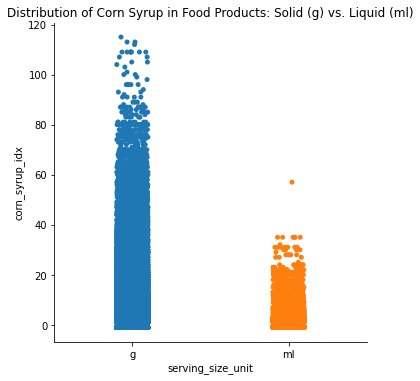

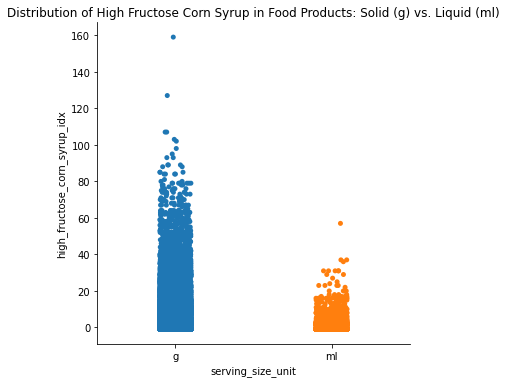

In [8]:
q1_main(csv_file="./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv")

In [9]:
# project01.question2
"""
This module provides the functions and code in support of answering the
question "How do popular brands fare with corn syrup and sugar?"

The `main()` function provides the pythonic driver, however this can
be run directly using python3 -m project01.question2 after the files
have been fetched from the USDA (see `project01.fetcher`).
"""

import pprint
import sys
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from typing import List

#import project01.parser as food_parser


def establish_food_object_cornsyrup(csv_file: str) -> FoodBrandObject:
#def establish_food_object_cornsyrup(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with corn syrup already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()

    bfood.run_on_df(insert_index, find="corn syrup")
#    bfood.run_on_df(food_parser.insert_index, find="corn syrup")
    return bfood

def establish_food_object_sugar(csv_file: str) -> FoodBrandObject:
#def establish_food_object_sugar(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with sugar already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()
    bfood.run_on_df(insert_index, find="sugar")
#    bfood.run_on_df(food_parser.insert_index, find="sugar")
    return bfood


def clamp_cornsyrup(bfood: BaseFood,
#def clamp_cornsyrup(bfood: food_parser.BaseFood,
                    floor: int = 0,
                    ceiling: int = None,
                    col: str = "corn_syrup_idx") -> pd.DataFrame:
    """Clamping function used to filter the allowed indices of a column.

    Args:
        bfood (food_parser.BaseFood): The dataframe to operate on.
        floor (int): The lowest allowed value of the column. Defaults to 0.
        ceiling (int): The highest allowed value in the column.
            Defaults to the maximum value in the column.
        col (str): The column name to operate on.  Defaults to corn_syrup_idx.

    Returns:
        pd.DataFrame: A new dataframe, where only the rows within the values
            of floor and ceiling are included, and all others are dropped.
    """
    return bfood.clamp(floor=floor, ceiling=ceiling, col=col)


def clamp_sugar(bfood: BaseFood,
#def clamp_sugar(bfood: food_parser.BaseFood,
                    floor: int = 0,
                    ceiling: int = None,
                    col: str = "sugar_idx") -> pd.DataFrame:
    """Clamping function used to filter the allowed indices of a column.

    Args:
        bfood (food_parser.BaseFood): The dataframe to operate on.
        floor (int): The lowest allowed value of the column. Defaults to 0.
        ceiling (int): The highest allowed value in the column.
            Defaults to the maximum value in the column.
        col (str): The column name to operate on.  Defaults to sugar_idx.

    Returns:
        pd.DataFrame: A new dataframe, where only the rows within the values
            of floor and ceiling are included, and all others are dropped.
    """
    return bfood.clamp(floor=floor, ceiling=ceiling, col=col)


def find_top_ten_brands(bfood: BaseFood,
#def find_top_ten_brands(bfood: food_parser.BaseFood,
                        col: str = "brand_owner") -> pd.DataFrame:
    """Establishes the dataset for top10 brands

    Args:
        bfood (food_parser.BaseFood): The dataframe to seek against.
        col (str): The column to find the top occurrences of.
    Returns:
        pd.DataFrame: A filtered dataframe containing only the brands
        in the top 10 largest categories.
    """
    return bfood.find_top(col=col, limit=10)


def metrics_on_brands(df: pd.DataFrame,
                               col: str = "brand_owner") -> List[pd.Series]:
    """Produces simple analysis on a specific column in a dataframe

    Args:
        df (pd.DataFrame): The dataframe to operate on.
        col (str): The column to perform analysis on.  Default: brand_owner.

    Returns:
        list[pd.Series]: The output of describe() and value_counts() on the dataframe's series.
    """
    return [df[col].describe(), df[col].value_counts()]


def plot_cornsyrup(df: pd.DataFrame, out: str = "plot.png"):
    """Creates a violin plot of the distribution of data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    # Note, we need to establish the figure to ensure sns doesn't
    # try to add to its prior plot.
    fig1, ax1 = plt.subplots(figsize=(12,6))
    sns.violinplot(x="corn_syrup_idx",
                            y="brand_owner",
                            orient="h",
                            data=df, ax=ax1).set(title="Top 10 brands: Corn Syrup")
    ax1.set(xlabel="Rank",
            ylabel="Brand Owner")
    # Calling plt.tight_layout() ensures our labels fit in our
    # plotting space.
    plt.tight_layout()
    fig1.savefig(out)


def plot_sugar(df: pd.DataFrame, out: str = "plot.png"):
    """Creates a violin plot of the distribution of data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.violinplot(x="sugar_idx",
                   y="brand_owner",
                   orient="h",
                   data=df, ax=ax1).set(title="Top 10 brands: Sugar")
    ax1.set(xlabel="Rank",
            ylabel="Brand Owner")
    # Calling plt.tight_layout() ensures our labels fit in our
    # plotting space.
    plt.tight_layout()
    fig.savefig(out)


def q2_main(csv_file: str):
#def main(csv_file: str):
    """Pythonic driver for our second question / query

    This method:
      1. Establishes our food object of interest
      2. Outputs trivial summary statistics on a column
      3. Establishes a subset to the top 10 brands
      4. Outputs metrics on the subset.
      5. Establishes another subset from the dataframe by limiting
         the data to only values that have corn syrup and sugar
      6. Produces a violin plot to show our data density across the
         top 10 groups.
     
    Args:
        csv_file (str): The path to the branded_foods.csv file.

    Returns:
        None: Output to the terminal statistics and various
        plots are written out to file.
    """
    bfood_cornsyrup = establish_food_object_cornsyrup(csv_file)
    print("metrics on brands with corn syrup:")
    pprint.pprint(metrics_on_brands(bfood_cornsyrup.df))
    df_cornsyrup = find_top_ten_brands(bfood_cornsyrup)
    print("---------------")
    print("metrics on top 10 brands with corn syrup:")
    pprint.pprint(metrics_on_brands(df_cornsyrup))
    metrics_on_brands(df_cornsyrup)
    df_cornsyrup_nomax = clamp_cornsyrup(bfood_cornsyrup)
    plot_cornsyrup(df_cornsyrup_nomax, out="q2-cornsyrup-unbound.png")
    df_cornsyrup_10max = clamp_cornsyrup(bfood_cornsyrup, ceiling=10)
    plot_cornsyrup(df_cornsyrup_10max, out="q2-cornsyrup-10max.png")

    print("---------------")

    bfood_sugar = establish_food_object_sugar(csv_file)
    print("metrics on brands with sugar:")
    pprint.pprint(metrics_on_brands(bfood_sugar.df))
    df_sugar = find_top_ten_brands(bfood_sugar)
    print("---------------")
    print("metrics on top 10 brands with sugar:")
    pprint.pprint(metrics_on_brands(df_sugar))
    metrics_on_brands(df_sugar)
    df_sugar_nomax = clamp_sugar(bfood_sugar)
    plot_sugar(df_sugar_nomax, out="q2-sugar-unbound.png")
    df_sugar_10max = clamp_sugar(bfood_sugar, ceiling=10)
    plot_sugar(df_sugar_10max, out="q2-sugar-10max.png")


#if __name__ == "__main__":
#    brand_csv = sys.argv[1] if len(sys.argv) > 2 else "./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv"
#    q2_main(csv_file=brand_csv)

metrics on brands with corn syrup:
[count                     469979
unique                     28491
top       Topco Associates, Inc.
freq                       12417
Name: brand_owner, dtype: object,
 Topco Associates, Inc.                          12417
Hy-Vee, Inc.                                     8192
Wal-Mart Stores, Inc.                            8063
Target Stores                                    8002
Meijer, Inc.                                     6223
                                                ...  
AMERICAN BREAKFAST                                  1
VIEIRA DE CASTRO - PRODUTOS ALIMENTARES, SA.        1
Comfort Foods Inc.                                  1
TEO                                                 1
Royito's Hot Sauce Company LLC                      1
Name: brand_owner, Length: 28491, dtype: int64]
---------------
metrics on top 10 brands with corn syrup:
[count                      66632
unique                        10
top       Topco Associates, In

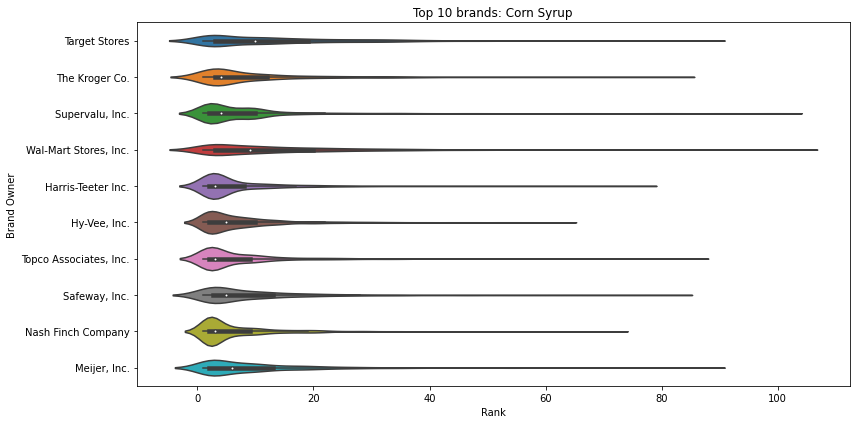

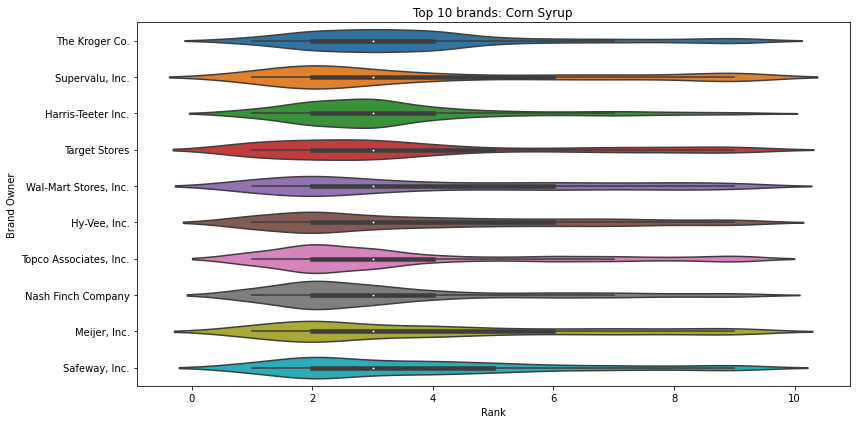

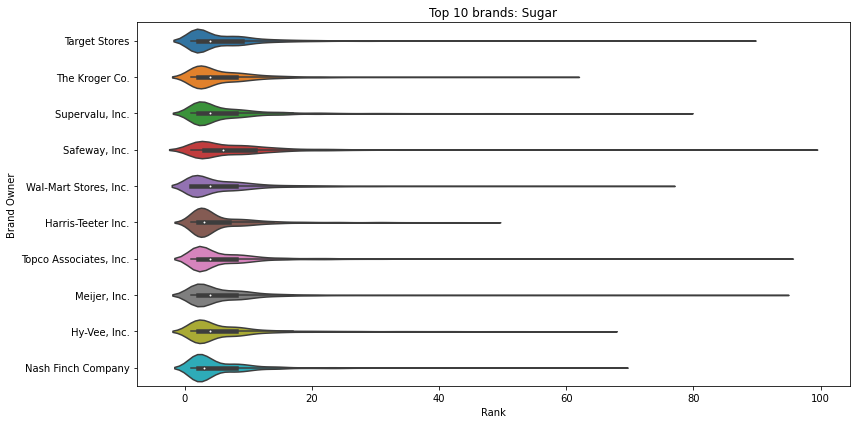

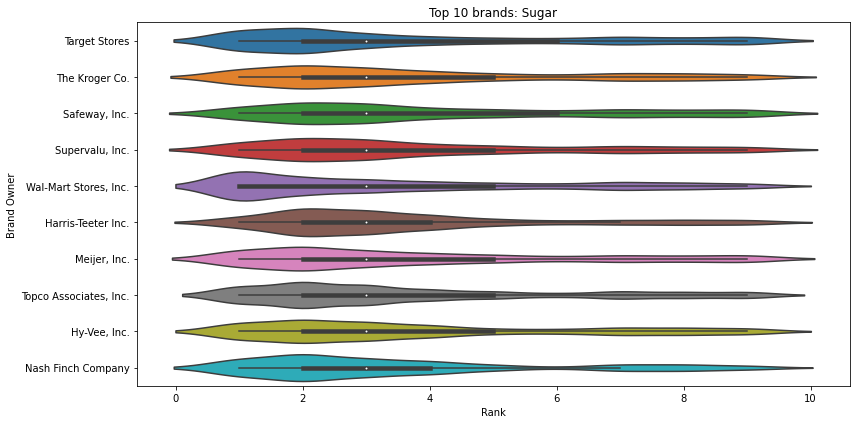

In [10]:
q2_main(csv_file="./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv")

In [11]:
# project01.question3
"""
This module provides the functions and code in support of answering the
question "How do popular food categories fare with corn syrup?"

The `main()` function provides the pythonic driver, however this can
be run directly using python3 -m project01.question3 after the files
have been fetched from the USDA (see `project01.fetcher`).
"""

import sys
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model as lm

from matplotlib import pyplot as plt
from typing import List

#import project01.parser as food_parser

def establish_food_object(csv_file: str) -> FoodBrandObject:
#def establish_food_object(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with corn syrup already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()
    bfood.run_on_df(insert_index, find="corn syrup")
#    bfood.run_on_df(food_parser.insert_index, find="corn syrup")
    bfood.run_on_df(insert_index, find="sugar")
#    bfood.run_on_df(food_parser.insert_index, find="sugar")
    return bfood

def clamp(bfood: BaseFood,
#def clamp(bfood: food_parser.BaseFood,
          floor: int = 0,
          ceiling: int = None,
          col: str = "corn_syrup_idx") -> pd.DataFrame:
    """Clamping function used to filter the allowed indices of a column.

    Args:
        bfood (food_parser.BaseFood): The dataframe to operate on.
        floor (int): The lowest allowed value of the column. Defaults to 0.
        ceiling (int): The highest allowed value in the column.
            Defaults to the maximum value in the column.
        col (str): The column name to operate on.  Defaults to corn_syrup_idx.

    Returns:
        pd.DataFrame: A new dataframe, where only the rows within the values
            of floor and ceiling are included, and all others are dropped.
    """
    return bfood.clamp(floor=floor, ceiling=ceiling, col=col)


def find_top_five_food_categories(bfood: BaseFood,
#def find_top_five_food_categories(bfood: food_parser.BaseFood,
                                  col: str = "branded_food_category") -> pd.DataFrame:
    """Establishes the dataset for top5 food categories

    Args:
        bfood (food_parser.BaseFood): The dataframe to seek against.
        col (str): The column to find the top occurrences of.
    Returns:
        pd.DataFrame: A filtered dataframe containing only the foods
        in the top five largest categories.
    """
    return bfood.find_top(col=col, limit=5)


def metrics_on_food_categories(df: pd.DataFrame,
                               col: str = "branded_food_category") -> List[pd.Series]:
    """Produces simple analysis on a specific column in a dataframe

    Args:
        df (pd.DataFrame): The dataframe to operate on.
        col (str): The column to perform analysis on.  Default: branded_food_category.

    Returns:
        list[pd.Series]: The output of describe() and value_counts() on the dataframe's series.
    """
    return [df[col].describe(), df[col].value_counts()]


def plot_foodcat(df: pd.DataFrame, col="corn_syrup_idx", out: str = "plot.png"):
    """Creates a violin plot of the distribution of data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        col (str): The column to use for the violinplot magnitude.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    # Note, we need to establish the figure to ensure sns doesn't
    # try to add to its prior plot.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.violinplot(x=col,
                   y="branded_food_category",
                   orient="h",
                   bw=0.2,
                   cut=0,
                   scale="width",
                   data=df, ax=ax1)
    ax1.set(xlabel="Rank",
            ylabel="Food Category")
    # Calling plt.tight_layout() ensures our labels fit in our
    # plotting space.
    plt.tight_layout()
    fig.savefig(out)


def density(bfood: BaseFood, out: str = ""):
#def density(bfood: food_parser.BaseFood, out: str = ""):
    newdf = pd.DataFrame({"brand": bfood.df["branded_food_category"],
                          "sugar": bfood.df["sugar_idx"],
                          "corn_syrup": bfood.df["corn_syrup_idx"]})
    # Insert NaNs for no matches to ensure our counts aren't skewed.
    newdf.loc[newdf["sugar"] == -1, "sugar"] = np.NaN
    newdf.loc[newdf["corn_syrup"] == -1, "corn_syrup"] = np.NaN
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.histplot(element="step", bins=30, ax=ax1, data=newdf)
    ax1.set(xlabel="Index",
            ylabel="Count")
    # Calling plt.tight_layout() ensures our labels fit in our
    # plotting space.
    plt.tight_layout()
    fig.savefig(out)


def correlation(bfood: BaseFood, out: str = "q3-correlation.png"):
#def correlation(bfood: food_parser.BaseFood, out: str = "q3-correlation.png"):
    newdf = pd.DataFrame({"category": bfood.df["branded_food_category"],
                          "sugar": bfood.df["sugar_idx"],
                          "corn_syrup": bfood.df["corn_syrup_idx"]})
    # Insert NaNs for no matches to ensure our counts aren't skewed.
    newdf.loc[newdf["sugar"] == -1, "sugar"] = np.NaN
    newdf.loc[newdf["corn_syrup"] == -1, "corn_syrup"] = np.NaN
    myfig = sns.pairplot(data=newdf, hue="category", markers="|", kind="reg")
    myfig.savefig(out)


def lin_model(df):
    newdf = pd.DataFrame({"category": df["branded_food_category"],
                          "sugar": df["sugar_idx"],
                          "corn_syrup": df["corn_syrup_idx"]})
    # Insert NaNs for no matches to ensure our counts aren't skewed.
    newdf.loc[newdf["sugar"] == -1, "sugar"] = np.NaN
    newdf.loc[newdf["corn_syrup"] == -1, "corn_syrup"] = np.NaN
    reg = lm.LinearRegression()
    X = newdf["corn_syrup"].values.reshape(-1, 1)
    y = newdf["sugar"].values.reshape(-1, 1)
    reg.fit(X, y)
    print(f"y = {reg.intercept_} + {reg.coef_}x")
    yhat = reg.predict(X)
    SSres = sum((y-yhat)**2)
    SSt = sum((y-np.mean(y))**2)
    rsq = 1 - (float(SSres))/SSt
    print(f"R2 = {rsq}")

def q3_main(csv_file: str):
    """Pythonic driver for our third question / query

    This method:
      1. Establishes our food object of interest
      2. Outputs trivial summary statistics on a column
      3. Establishes a subset to the top five food categories
      4. Outputs metrics on the subset.
      5. Establishes another subset from the dataframe by limiting
         the data to only values that have corn syrup
      6. Produces a violin plot to show our data density across the
         top five groups.  We see a large left tail.
      7. After reviewing the data, the corn_syrup_idx ceiling appears
         to be near ten, so we further clamp the data down to center
         our distribution.

    Args:
        csv_file (str): The path to the branded_foods.csv file.

    Returns:
        None: Output to the terminal statistics and various
        plots are written out to file.
    """
    bfood = establish_food_object(csv_file)
    df = find_top_five_food_categories(bfood)
    print(metrics_on_food_categories(bfood.df))
    # Very wide range, adjusted to 10 as this seems to match most index returns.
    df_cornsyrup = clamp(bfood)
    plot_foodcat(df_cornsyrup, out="q3-cornsyrup-cat.png")
    df_sugar = clamp(bfood, col="sugar_idx")
    plot_foodcat(df_sugar, out="q3-sugar.png")
    density(bfood, out="q3-density.png")
    correlation(bfood, out="q3-correlation.png")
    lin_model(bfood.df)


#if __name__ == "__main__":
#    brand_csv = sys.argv[1] if len(sys.argv) > 2 else "./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv"
#    main(csv_file=brand_csv)

[count                                        89898
unique                                           5
top       Popcorn, Peanuts, Seeds & Related Snacks
freq                                         21322
Name: branded_food_category, dtype: object, Popcorn, Peanuts, Seeds & Related Snacks    21322
Candy                                       20783
Cheese                                      18671
Ice Cream & Frozen Yogurt                   15480
Cookies & Biscuits                          13642
Name: branded_food_category, dtype: int64]
y = [2.13423854] + [[0.11217854]]x
R2 = [0.08530698]


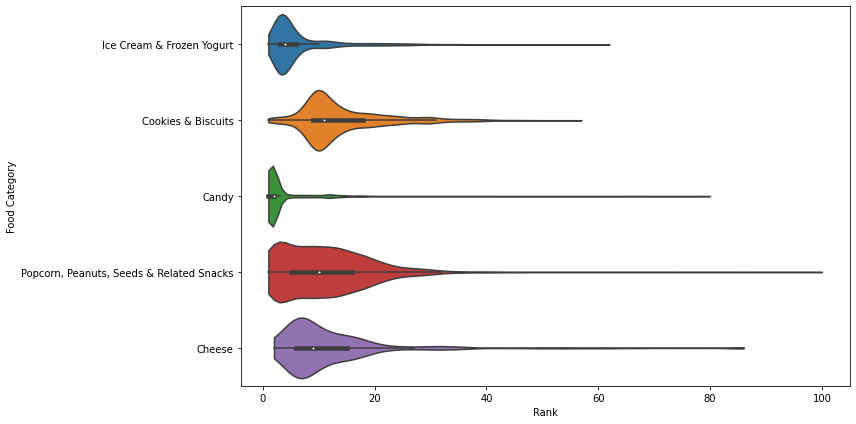

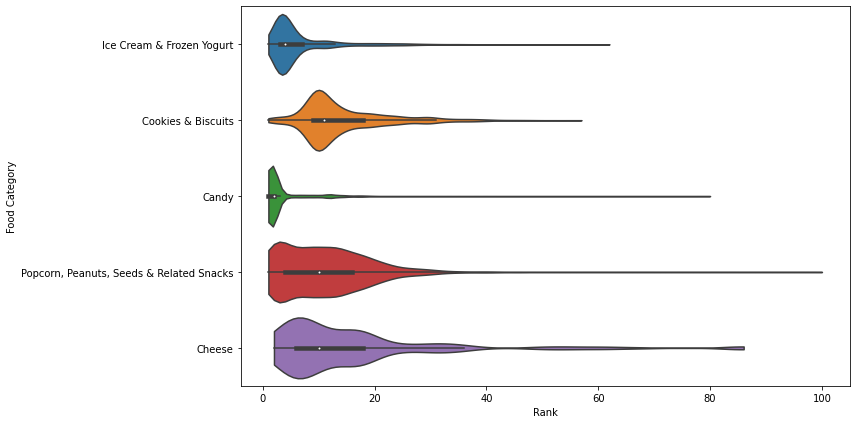

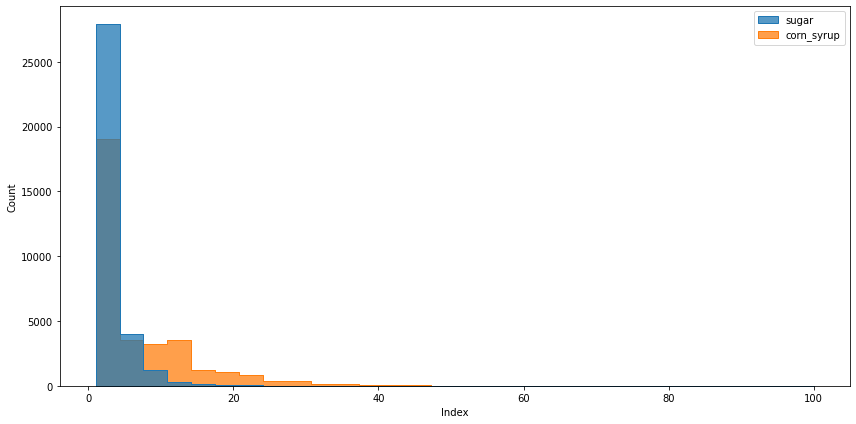

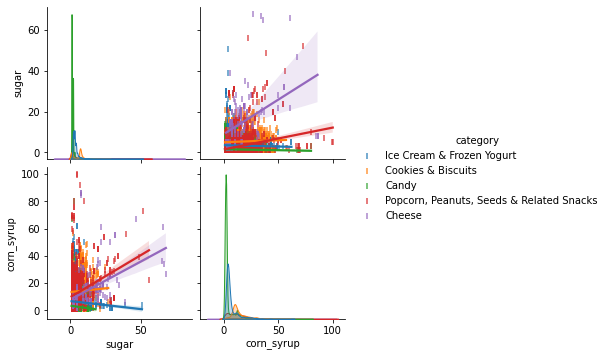

In [12]:
q3_main(csv_file="./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv")

In [13]:
# project01.question4
"""
This module provides the functions and code in support of answering the
question "How do solid food items (grams) and liquid item (ml) fare with corn syrup and sugar?"

The `main()` function provides the pythonic driver, however this can
be run directly using python3 -m project01.question4 after the files
have been fetched from the USDA (see `project01.fetcher`).
"""

import sys
import pandas as pd
import seaborn as sns

#import project01.parser as food_parser

def establish_food_object_cornsyrup(csv_file: str) -> FoodBrandObject:
#def establish_food_object_cornsyrup(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with corn syrup already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()
    cornsyrup = bfood.run_on_df(insert_index, "corn syrup", "ingredients")
#    cornsyrup = bfood.run_on_df(food_parser.insert_index, "corn syrup", "ingredients")
    return cornsyrup


def establish_food_object_sugar(csv_file: str) -> FoodBrandObject:
#def establish_food_object_sugar(csv_file: str) -> food_parser.FoodBrandObject:
    """Creates our food object leveraging our general purpose parser.

    Args:
        csv_file (str): The path to the food brand CSV file.

    Returns:
        food_parser.FoodBrandObject: A general purpose brand object which
            contains the parsed dataframe with sugar already added as
            a new index.
    """
    bfood = FoodBrandObject(csv_file)
#    bfood = food_parser.FoodBrandObject(csv_file)
    bfood.cleanup()
    sugar = bfood.run_on_df(insert_index, "sugar", "ingredients")
#    sugar = bfood.run_on_df(food_parser.insert_index, "sugar", "ingredients")
    return sugar


def plot_cornsyrup(df: pd.DataFrame, out: str = "plot.png"):
    """Creates a catplot of the data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    fig = sns.catplot(x="serving_size_unit",
                      y="corn_syrup_idx",
                      data=df).set(title="Serving Size: Corn Syrup")
    fig.savefig(out)


def plot_sugar(df: pd.DataFrame, out: str = "plot.png"):
    """Creates a catplot of the data.

    Args:
        df (pd.DataFrame): The dataframe to use when plotting.
        out (str): The path to save the plotting graphic to.

    Returns:
        None: The graphic is saved to `out` as a side effect.
    """
    fig = sns.catplot(x="serving_size_unit",
                      y="sugar_idx",
                      data=df).set(title="Serving Size: Sugar")
    fig.savefig(out)


def q4_main(csv_file: str):
    """Pythonic driver for our fourth question / query

    This method:
      1. Establishes our food object of interest
      2. Establishes subset from the dataframe by limiting
         the data to only values that have corn syrup
      3. Produces a catplot to compare solid and liquid food item's data

    Args:
        csv_file (str): The path to the branded_foods.csv file.

    Returns:
        None: catplot is written out to file.
    """
    cornsyrup = establish_food_object_cornsyrup(csv_file)
    plot_cornsyrup(cornsyrup, out="q4-cornsyrup.png")

    sugar = establish_food_object_sugar(csv_file)
    plot_sugar(sugar, out="q4-sugar.png")


#if __name__ == "__main__":
#    brand_csv = sys.argv[1] if len(sys.argv) > 2 else "../dataset/FoodData_Central_csv_2020-10-30/branded_food.csv"
#    main(csv_file=brand_csv)

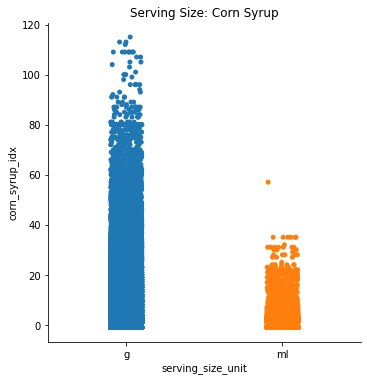

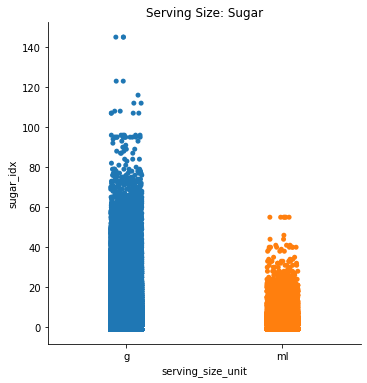

In [14]:
q4_main(csv_file="./dataset/FoodData_Central_csv_2020-10-30/branded_food.csv")

In [15]:
# Setup test data

# test/test_parser/branded_food.csv
!echo '"fdc_id","brand_owner","gtin_upc","ingredients","serving_size","serving_size_unit","household_serving_fulltext","branded_food_category","data_source","modified_date","available_date","market_country","discontinued_date"' > test_branded_food.csv
!echo '"344604","Red Gold","00072940755050","Tomatoes, Tomato Juice, Less Than 2% Of: Salt, Dried Onion, Dried Garlic, Soybean Oil, Spices, Calcium Chloride, Natural Flavor, Olive Oil, Citric Acid.","123","g","1/2 cup","","GDSN","2018-04-26","2019-04-01","United States",""' >> test_branded_food.csv
!echo  '"344605","Red Gold","00072940755043","Tomatoes, Tomato Juice, Less Than 2% Of: Salt, Dried Onion, Dried Garlic, Soybean Oil, Spices, Calcium Chloride, Natural Flavor, Olive Oil, Citric Acid.","123","g","1/2 cup","","GDSN","2018-04-26","2019-04-01","United States",""' >> test_branded_food.csv
!echo '"344606","Cargill","00642205534517","White Turkey, Natural Flavoring","112","g","4 oz.","","GDSN","2016-06-13","2019-04-01","United States",""' >> test_branded_food.csv
!echo '"344609","Kellogg Company US","00038000934490","ENRICHED FLOUR (WHEAT FLOUR, NIACIN, REDUCED IRON, VITAMIN B1 [THIAMIN MONONITRATE], VITAMIN B2 [RIBOFLAVIN], FOLIC ACID), CORN SYRUP, HIGH FRUCTOSE CORN SYRUP, SUGAR, SOYBEAN AND PALM OIL (WITH TBHQ FOR FRESHNESS), DEXTROSE, CONTAINS TWO PERCENT OR LESS OF WHEAT STARCH, CRACKER MEAL, GLYCERIN, SALT, DRIED CHERRIES, DRIED APPLES, LEAVENING (BAKING SODA, SODIUM ACID PYROPHOSPHATE, MONOCALCIUM PHOSPHATE), CITRIC ACID, MILLED CORN, GELATIN, MALIC ACID, RED 40 LAKE, XANTHAN GUM, MODIFIED CORN STARCH, MODIFIED WHEAT STARCH, SOY LECITHIN, COLOR ADDED, NATURAL AND ARTIFICIAL FLAVOR, RED 40, NIACINAMIDE, BLUE 2 LAKE, REDUCED IRON, CARMINE COLOR, VITAMIN A PALMITATE, TURMERIC FOR COLOR, VITAMIN B6 (PYRIDOXINE HYDROCHLORIDE), VITAMIN B2 (RIBOFLAVIN), VITAMIN B1 (THIAMIN HYDROCHLORIDE), BLUE 1.","50","g","1 Pastry","Pies/Pastries - Sweet (Shelf Stable)","GDSN","2018-01-22","2019-04-01","United States",""' >> test_branded_food.csv

!cat test_branded_food.csv

# test/test_parser/rating.csv
!echo 'id,branded_food_category,alt_category' > test_rating.csv
!echo '1,category1,test1' >> test_rating.csv
!echo '2,category1,test2' >> test_rating.csv
!echo '3,category1,test1' >> test_rating.csv
!echo '4,category2,test2' >> test_rating.csv
!echo '5,category2,test3' >> test_rating.csv
!echo '5,category3,test3' >> test_rating.csv
!echo '8,category4,test4' >> test_rating.csv
!echo '9,category4,test5' >> test_rating.csv
!echo '10,category5,test6' >> test_rating.csv
!echo '10,category5,test7' >> test_rating.csv
!echo '11,category6,test7' >> test_rating.csv
!echo '13,category7,test8' >> test_rating.csv
!echo '14,category5,test8' >> test_rating.csv
!echo '15,category8,test9' >> test_rating.csv
!echo '15,category8,test10' >> test_rating.csv
!echo '15,category9,test10' >> test_rating.csv
!echo '15,category9,test10' >> test_rating.csv

!cat test_rating.csv

# test/test_parser/simple.csv
!echo 'id,corn_syrup_idx,tester' > test_simple.csv
!echo '0,-1,row1' >> test_simple.csv
!echo '1,0,row2' >> test_simple.csv
!echo '2,33,row4' >> test_simple.csv
!echo '5,22,row5' >> test_simple.csv
!echo '8,-342,row6' >> test_simple.csv
!echo '-2,-58,row7' >> test_simple.csv

!cat test_rating.csv

"fdc_id","brand_owner","gtin_upc","ingredients","serving_size","serving_size_unit","household_serving_fulltext","branded_food_category","data_source","modified_date","available_date","market_country","discontinued_date"
"344604","Red Gold","00072940755050","Tomatoes, Tomato Juice, Less Than 2% Of: Salt, Dried Onion, Dried Garlic, Soybean Oil, Spices, Calcium Chloride, Natural Flavor, Olive Oil, Citric Acid.","123","g","1/2 cup","","GDSN","2018-04-26","2019-04-01","United States",""
"344605","Red Gold","00072940755043","Tomatoes, Tomato Juice, Less Than 2% Of: Salt, Dried Onion, Dried Garlic, Soybean Oil, Spices, Calcium Chloride, Natural Flavor, Olive Oil, Citric Acid.","123","g","1/2 cup","","GDSN","2018-04-26","2019-04-01","United States",""
"344606","Cargill","00642205534517","White Turkey, Natural Flavoring","112","g","4 oz.","","GDSN","2016-06-13","2019-04-01","United States",""
"344609","Kellogg Company US","00038000934490","ENRICHED FLOUR (WHEAT FLOUR, NIACIN, REDUCED IRON, VITA

In [16]:
# test/test_fetch.py

#import project01.fetch as fetch
import tempfile

import pytest

@pytest.fixture
def tempfile_setup():
    with tempfile.NamedTemporaryFile(mode="w") as tf:
        yield tf


def test_constructor(tempfile_setup):
    fetcher = Fetcher(uris=tempfile_setup.name, base="testbase", feedback=False)
#    fetcher = fetch.Fetcher(uris=tempfile_setup.name, base="testbase", feedback=False)
    assert fetcher._uris == []
    assert fetcher._base == "testbase"
    assert fetcher._feedback == False


def test_parse_file(tempfile_setup):
    print(tempfile_setup)
    tempfile_setup.write("Testlinegood\n")
    tempfile_setup.write("#Commented line\n")
    tempfile_setup.write("2Testlinegood")
    tempfile_setup.flush()
    fetcher = Fetcher(uris=tempfile_setup.name)
#    fetcher = fetch.Fetcher(uris=tempfile_setup.name)
    assert fetcher._uris == ["Testlinegood", "2Testlinegood"] 


def test_add_uri(tempfile_setup):
    tempfile_setup.write("Testlinegood\n")
    tempfile_setup.flush()
    fetcher = Fetcher(uris=tempfile_setup.name)
#    fetcher = fetch.Fetcher(uris=tempfile_setup.name)
    fetcher.add_uri("next-line")
    assert fetcher._uris == ["Testlinegood", "next-line"]


def test_fetch():
    # Will need to spy this
    pass

In [17]:
# test/test_parser.py


import pandas as pd

#import project01.parser as parser

@pytest.fixture
def datadir():
    class innerclass():
        @staticmethod
        def join(arg):
            return os.path.join("./", arg)
    return innerclass()

def test_food_object_inheritance(datadir):
    fb_object = FoodBrandObject(datadir.join("test_branded_food.csv"))
#    fb_object = parser.FoodBrandObject(datadir.join("branded_food.csv"))
    assert issubclass(type(fb_object), BaseFood)
#    assert issubclass(type(fb_object), parser.BaseFood)


def test_insert_index_col(datadir):
    bfood = BaseFood(datadir.join("test_branded_food.csv"))
#    bfood = parser.BaseFood(datadir.join("branded_food.csv"))
    bfood.run_on_df(insert_index, "salt", "ingredients")
#    bfood.run_on_df(parser.insert_index, "salt", "ingredients")
    assert "salt_idx" in bfood.df


def test_find_index_from_str(datadir):
    bfood = BaseFood(datadir.join("test_branded_food.csv"))
#    bfood = parser.BaseFood(datadir.join("branded_food.csv"))
    bfood.run_on_df(insert_index, "salt", "ingredients")
#    bfood.run_on_df(parser.insert_index, "salt", "ingredients")
    assert bfood.df["salt_idx"].equals(pd.DataFrame({"salt_idx": [3, 3, -1, 15]})["salt_idx"])


def test_clamp(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    bfood.clamp()
    assert len(bfood.df) == 2


def test_cornsyrup_clamp_defaults(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    ret = bfood.clamp()
    assert len(bfood.df) == 2
    assert isinstance(ret, pd.DataFrame)
    assert bfood.df.equals(ret)


def test_cornsyrup_clamp_returntype(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
  #  bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    ret = bfood.clamp()
    assert isinstance(ret, pd.DataFrame)


def test_cornsyrup_clamp_mutates_df(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    ret = bfood.clamp()
    assert bfood.df.equals(ret)


def test_cornsyrup_clamp_alt_column(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["id"] = pd.to_numeric(bfood.df["id"])
    bfood.clamp(col="id")
    assert len(bfood.df) == 4


def test_cornsyrup_clamp_alt_floor(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    bfood.clamp(floor=-5)
    assert len(bfood.df) == 4


def test_cornsyrup_clamp_alt_floor2(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    bfood.clamp(floor=-10000)
    assert len(bfood.df) == 6


def test_cornsyrup_clamp_alt_ceil(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    bfood.clamp(ceiling=25)
    assert len(bfood.df) == 1


def test_cornsyrup_clamp_alt_constrained(datadir):
    bfood = BaseFood(datadir.join("test_simple.csv"))
#    bfood = parser.BaseFood(datadir.join("simple.csv"))
    bfood.df["corn_syrup_idx"] = pd.to_numeric(bfood.df["corn_syrup_idx"])
    bfood.clamp(floor=-60, ceiling=25)
    assert len(bfood.df) == 4


def test_find_top_default(datadir):
    bfood = BaseFood(datadir.join("test_rating.csv"))
#    bfood = parser.BaseFood(datadir.join("rating.csv"))
    df_result = bfood.find_top()
    assert len(df_result["branded_food_category"].unique()) == 5


def test_find_top_specified_amount(datadir):
    bfood = BaseFood(datadir.join("test_rating.csv"))
#    bfood = parser.BaseFood(datadir.join("rating.csv"))
    df_result = bfood.find_top(limit=7)
    assert len(df_result["branded_food_category"].unique()) == 7


def test_find_top_specified_col(datadir):
    bfood = BaseFood(datadir.join("test_rating.csv"))
#    bfood = parser.BaseFood(datadir.join("rating.csv"))
    df_result = bfood.find_top(col="alt_category")
    assert len(df_result["alt_category"].unique()) == 5


def test_find_top_specified_limit_and_col(datadir):
    bfood = BaseFood(datadir.join("test_rating.csv"))
#    bfood = parser.BaseFood(datadir.join("rating.csv"))
    df_result = bfood.find_top(col="alt_category", limit=3)
    assert len(df_result["alt_category"].unique()) == 3

In [18]:
pytest.main(args=['-sv'])

============================= test session starts ==============================
platform linux -- Python 3.7.10, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: jupyter-pytest-2-1.0.1, typeguard-2.7.1
collecting ... collected 20 items

::test_constructor PASSED
::test_parse_file <tempfile._TemporaryFileWrapper object at 0x7f0b0d4c1890>
PASSED
::test_add_uri PASSED
::test_fetch PASSED
::test_food_object_inheritance PASSED
::test_insert_index_col PASSED
::test_find_index_from_str PASSED
::test_clamp PASSED
::test_cornsyrup_clamp_defaults PASSED
::test_cornsyrup_clamp_returntype PASSED
::test_cornsyrup_clamp_mutates_df PASSED
::test_cornsyrup_clamp_alt_column PASSED
::test_cornsyrup_clamp_alt_floor PASSED
::test_cornsyrup_clamp_alt_floor2 PASSED
::test_cornsyrup_clamp_alt_ceil PASSED
::test_cornsyrup_clamp_alt_constrained PASSED
::test_find_top_default PASSED
::test_find_top_specified_amount PASSED
::test_find_top_specified_co

<ExitCode.OK: 0>